# Garmin Project Jupyter Notebook

---


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pytz


---

## Overview:
 1. Preprocess .csv files for viable graphing
 2. Present a few different research questions
 3. Create graphs that show these correlations


---


# Sleep


In [ ]:
sleep = pd.read_csv('./data_final/sleep_final.csv')
sleep.info()
sleep.head()

In [3]:
#Convert the calendarDate column to pd.datetime (prep for the combine dataframe)
sleep['calendarDate'] = pd.to_datetime(sleep['calendarDate'])

#add a 'date' column that doesn't have the time (used for later combining the datasets)
sleep['date'] = sleep['calendarDate'].dt.date

#add days of the week to each entry
sleep['dayOfWeek'] = sleep['calendarDate'].dt.day_name()

#change GMT to CST for graphing
sleep['sleepStartTimestampGMT'] = pd.to_datetime(sleep['sleepStartTimestampGMT'])
sleep['sleepEndTimestampGMT'] = pd.to_datetime(sleep['sleepEndTimestampGMT'])

#Convert 'sleepStartTimestampGMT' and 'sleepEndTimestampGMT' from GMT to CST
sleep['sleepStartTimestampGMT'] = sleep['sleepStartTimestampGMT'].dt.tz_localize('GMT')
sleep['sleepEndTimestampGMT'] = sleep['sleepEndTimestampGMT'].dt.tz_localize('GMT')
sleep['sleepStartTimestampCST'] = sleep['sleepStartTimestampGMT'].dt.tz_convert('US/Central')
sleep['sleepEndTimestampCST'] = sleep['sleepEndTimestampGMT'].dt.tz_convert('US/Central')

#remove time difference
sleep['sleepStartTimestampCST'] = sleep['sleepStartTimestampCST'].dt.tz_localize(None)
sleep['sleepEndTimestampCST'] = sleep['sleepEndTimestampCST'].dt.tz_localize(None)

In [ ]:
sleep.head()

### Graphs

In [5]:
#create column for the hour I go to sleep
sleep['sleepStartHour'] = sleep['sleepStartTimestampCST'].dt.hour

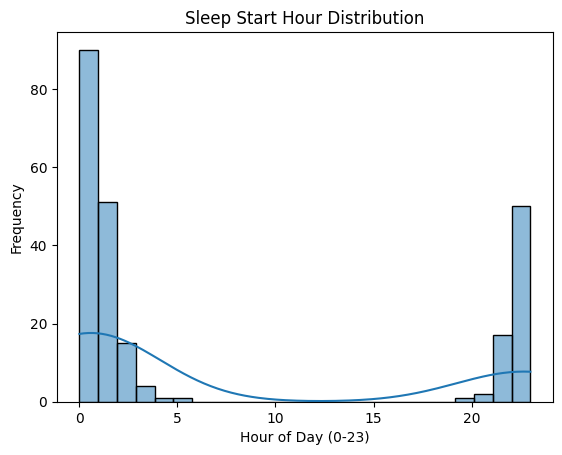

In [29]:
#diagram of sleep start hours
sns.histplot(data=sleep, x='sleepStartHour', bins=24, kde=True)
plt.title('Sleep Start Hour Distribution')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Frequency')
plt.show()

In [7]:
#create column for hour of sleep ending
sleep['sleepEndHour'] = sleep['sleepEndTimestampCST'].dt.hour

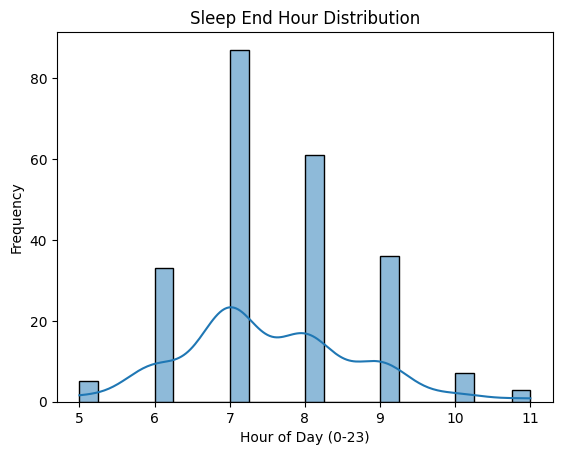

In [8]:
#diagram of sleep end hours
sns.histplot(data=sleep, x='sleepEndHour', bins=24, kde=True)
plt.title('Sleep End Hour Distribution')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Frequency')
plt.show()

In [9]:
#get total minutes and then hours slept
sleep['totalSleepSeconds'] = sleep['deepSleepSeconds'] + sleep['lightSleepSeconds'] + sleep['remSleepSeconds'] + sleep['awakeSleepSeconds']
sleep['totalSleepMinutes'] = sleep['totalSleepSeconds'] / 60
sleep['totalSleepHours'] = sleep['totalSleepMinutes'] / 60

In [ ]:
sleep.head()

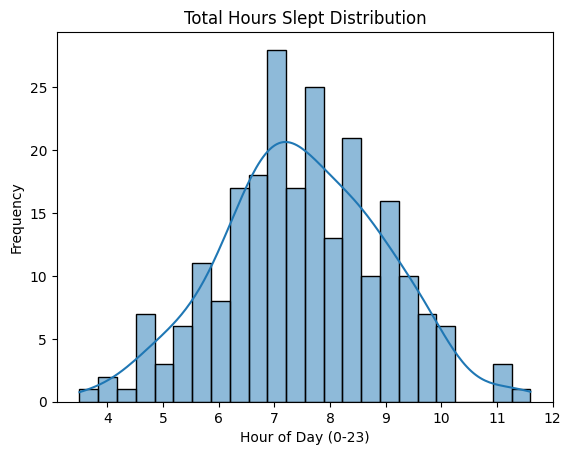

In [11]:
#diagram of total sleep hours
sns.histplot(data=sleep, x='totalSleepHours', bins=24, kde=True)
plt.title('Total Hours Slept Distribution')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Frequency')
plt.show()

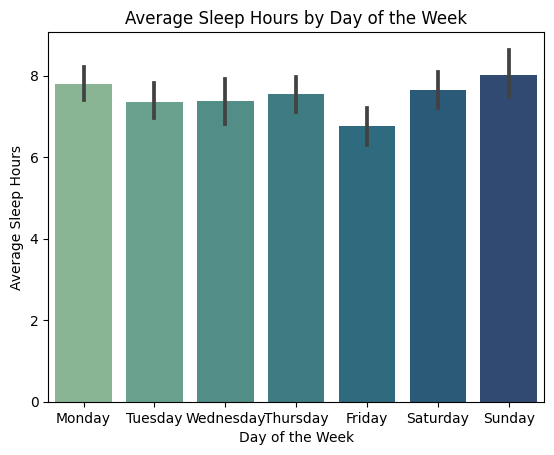

In [12]:
#Bar plot of the avg. amount of sleep hours by Day of the Week
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.barplot(data=sleep, x='dayOfWeek', y='totalSleepHours', order=days, palette='crest')
plt.title('Average Sleep Hours by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sleep Hours')
plt.show()



---

# Activities


In [ ]:
activities = pd.read_csv('./data_final/activities_final.csv')
activities.info()
activities.head()

In [18]:
#Convert the Date column to pd.datetime (prep for the combine dataframe)
activities['Date'] = pd.to_datetime(activities['Date'])

#add a 'date' column that doesn't have the time (used for later combining the datasets)
activities['date'] = activities['Date'].dt.date

#add days of the week to each entry
activities['dayOfWeek'] = activities['Date'].dt.day_name()

#sort by day for graphing
activities = activities.sort_values(by='date')

In [ ]:
activities.info()

---

## Graphs


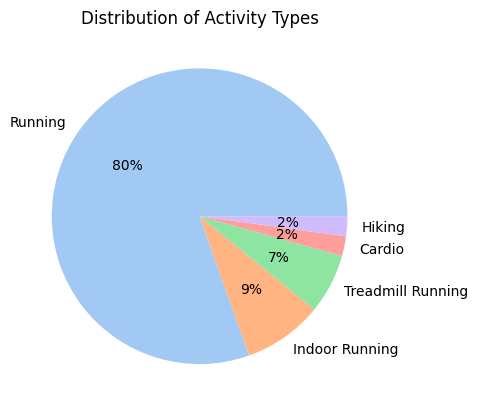

In [19]:
#Pie chart to show activity distribution
#Make a series of the counts, then colors based on amt of activities, then plot
activityCounts = activities['Activity Type'].value_counts()
colors = sns.color_palette('pastel')[0:len(activityCounts)]
plt.pie(activityCounts, labels = activityCounts.index, colors = colors, autopct='%.0f%%')
plt.title('Distribution of Activity Types')
plt.show()

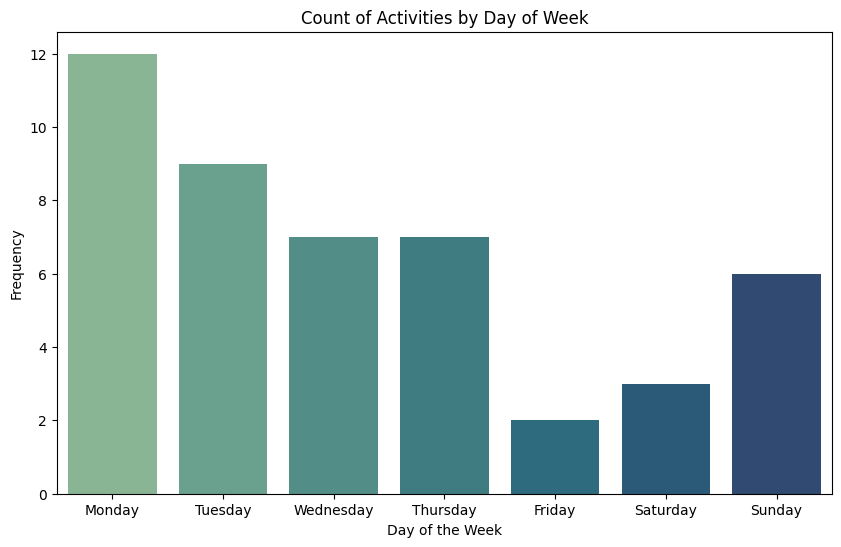

In [20]:
#Plot what day of the week most activities were recorded
plt.figure(figsize=(10,6))
sns.countplot(x='dayOfWeek', data=activities, order=days, palette='crest')
plt.title('Count of Activities by Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.show()

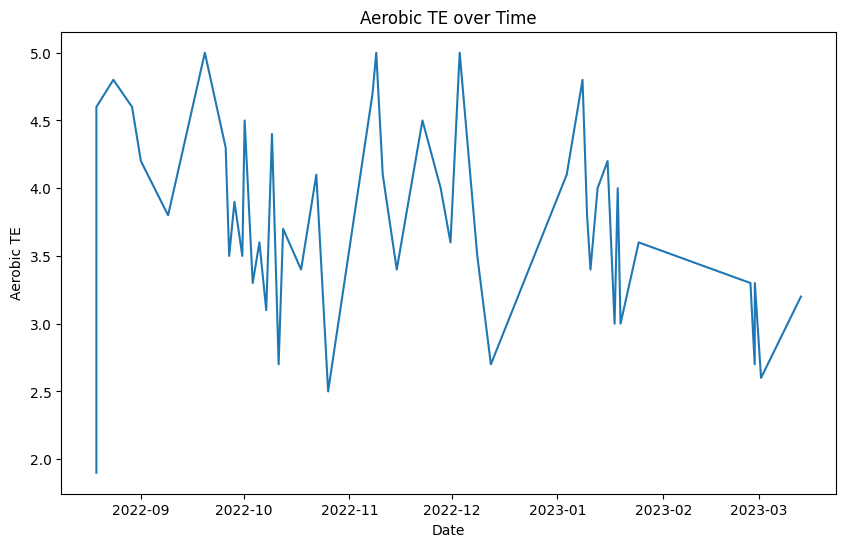

In [21]:
#Plot Aerobic Training Effect to show how it has changed during training
plt.figure(figsize=(10,6))
sns.lineplot(data=activities, x='Date', y='Aerobic TE')
plt.title('Aerobic TE over Time')
plt.xlabel('Date')
plt.ylabel('Aerobic TE')
plt.show()

In [22]:
#Want to look at Avg. Pace over time compared to Heart Rate
activities['Avg Pace'].info()
#Says it's an object, so need to turn them into numeric values first / went back and added if due to empty values
def convertPace(pace):
    if ':' in pace:
        min, sec = pace.split(':')
        return int(min) + int(sec) / 60
    else:
        return None

activities['Avg Pace'] = activities['Avg Pace'].apply(convertPace)

<class 'pandas.core.series.Series'>
Int64Index: 46 entries, 45 to 0
Series name: Avg Pace
Non-Null Count  Dtype 
--------------  ----- 
46 non-null     object
dtypes: object(1)
memory usage: 736.0+ bytes


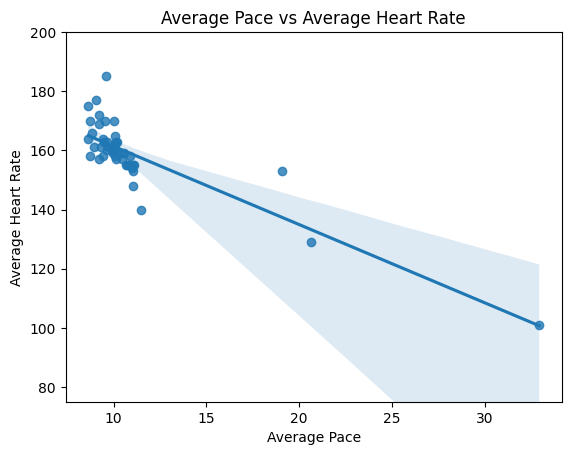

In [23]:
activities['Avg Pace'] = pd.to_numeric(activities['Avg Pace'])
sns.regplot(data=activities, x='Avg Pace', y='Avg HR')
plt.title('Average Pace vs Average Heart Rate')
plt.xlabel('Average Pace')
plt.ylabel('Average Heart Rate')
plt.ylim(75,200)
plt.show()



---
# Combined


In [24]:
combined = pd.merge(sleep, activities, on='date', how='left')

In [ ]:
combined.head()

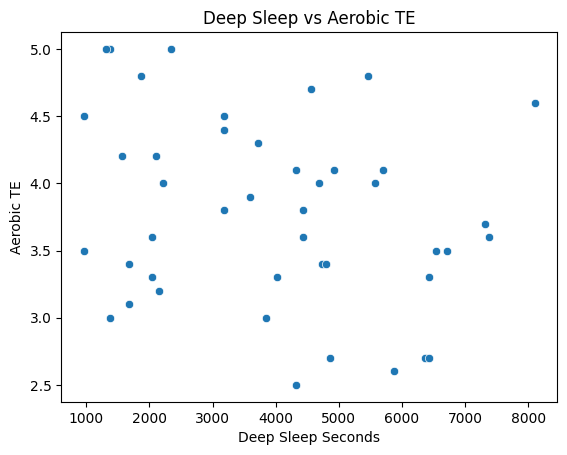

In [26]:
sns.scatterplot(data=combined, x='deepSleepSeconds', y='Aerobic TE')
plt.title('Deep Sleep vs Aerobic TE')
plt.xlabel('Deep Sleep Seconds')
plt.ylabel('Aerobic TE')
plt.show()

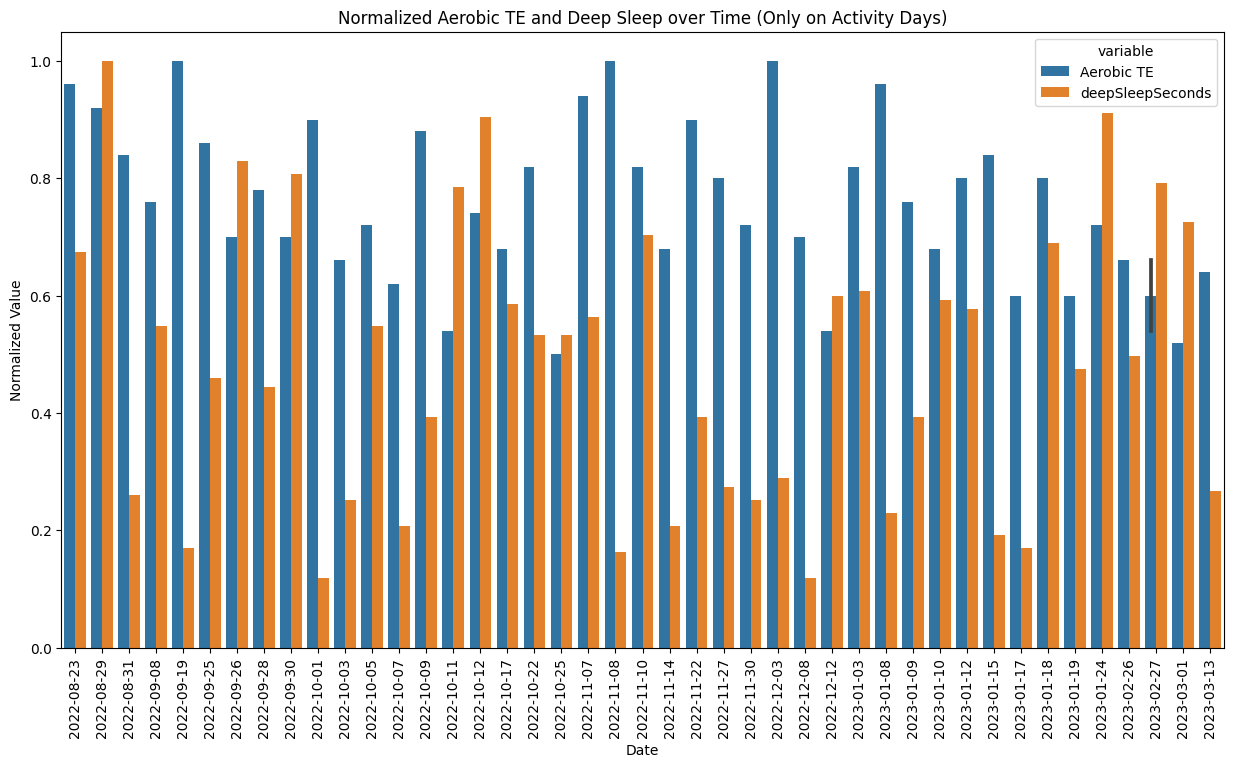

In [28]:
combinedByActivity = combined[combined['Activity Type'].notna()]
combinedByActivity = combinedByActivity.copy()

# Normalize 'Aerobic TE' and 'deepSleepSeconds'
combinedByActivity['Aerobic TE'] /= combinedByActivity['Aerobic TE'].max()
combinedByActivity['deepSleepSeconds'] /= combinedByActivity['deepSleepSeconds'].max()

# Convert the dataframe to long format
combinedLong = pd.melt(combinedByActivity, id_vars='date', value_vars=['Aerobic TE', 'deepSleepSeconds'])

# Create the barplot
plt.figure(figsize=(15, 8))
sns.barplot(data=combinedLong, x='date', y='value', hue='variable')
plt.title('Normalized Aerobic TE and Deep Sleep over Time (Only on Activity Days)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.xticks(rotation=90)
plt.show()